# Importa as bibliotecas de uso comum

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from os import listdir
from os.path import isfile, join

# Importa o Keras e os modelos pré-treinados

In [2]:
import keras

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.models import Model
from keras.models import Sequential

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau




In [3]:
keras.__version__

'2.5.0'

# Monta o Google Drive e define o diretorio das images

In [4]:
# Accessing My Google Drive
drive.mount('/content/drive',  force_remount=True)

#DATASET = 'drive/My Drive/UMLstudies/dataset_UML'
#CSV_DATASET = 'drive/My Drive/UMLstudies/dataset_UML.csv'
DATASET = 'drive/My Drive/UMLstudies/augmented_UML'
CSV_DATASET = 'drive/My Drive/UMLstudies/augmented_UML.csv'

SAVED_MODELS = 'drive/My Drive/UMLstudies/Models/Inception/'

TEST_DIR = 'drive/My Drive/UMLstudies/dataset_UML_test'

Mounted at /content/drive


# Parametros variáveis para teste de treinamento

In [5]:
HEIGHT = 299
WIDTH = 299
COLOR_DEPTH = 3


BATCH_SIZE = 32
TESTE_NUM = 7
NUM_EPOCHS = 10
K_FOLD = 10


# Carrega o dataset
## A fazer
- Melhorar imagens para treino
- Verificar a  Validação
- Criar dataser de teste

In [ ]:
#train_datagen=ImageDataGenerator(preprocessing_function = preprocess_input_resnet50) #included in our dependencies

idg=ImageDataGenerator(preprocessing_function = preprocess_input) #included in our dependencies

# idg = ImageDataGenerator(
#         rescale=1 / 255.0,
#         rotation_range=20,
#         zoom_range=0.05,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         shear_range=0.05,
#         horizontal_flip=True,
#         fill_mode="nearest",
#         validation_split=0.20)



train_data = pd.read_csv(CSV_DATASET)
Y = train_data[['classes']]
n = Y.count()

print(n)
kf = KFold(n_splits = K_FOLD)
                         
skf = StratifiedKFold(n_splits = K_FOLD, random_state = 7, shuffle = True) 


classes    6000
dtype: int64


# Utilidades 

In [ ]:

def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVED_MODELS, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

# Salva os modelos

In [ ]:
def get_model_name(k):
    return 'model_Inception_'+str(k)+'.h5'

 # Carrega o modelo InceptionV3 para extraçao de caracteristicas

In [ ]:
def create_new_model():

    #Instantiate a base model with pre-trained weigts. 
    inception = InceptionV3(weights='imagenet',include_top=False, input_shape=(HEIGHT, WIDTH, COLOR_DEPTH)) 

    # for layer in inception.layers:
    #     layer.trainable=False

    # 	# Unfreeze Layers
    for layer in inception.layers[:175]:
    	    layer.trainable = False
    for layer in inception.layers[175:]:
    	    layer.trainable = True

    output = inception.layers[-1].output 
    output = keras.layers.Flatten()(output) 

    model = inception.output
    model = GlobalAveragePooling2D()(model)
    #model = Dense(2048, activation='relu')(model)
    #model = Dropout(0.25)(model)

    predicao = Dense(6,activation='softmax')(model) 
    model=Model(inputs=inception.input,outputs=predicao)


    return model

In [ ]:
model.get_config()

NameError: ignored

# explora o modelo

In [ ]:
model = create_new_model()
print(model.summary())


for i, layer in enumerate(model.layers):
    print(i, layer.name)


In [ ]:
trainable_params = 16048710
unfroozenLayer = 174

In [ ]:
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

# Interacoes do K-FOLD

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

TRAIN_LOSS = []
TRAIN_ACCURACY = []

FOLD_VAR = 1

for train_index, val_index in skf.split(np.zeros(n),Y):
	print('\n-------\nK-FOLD ', FOLD_VAR)
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]

	
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = DATASET,
						       x_col = "id", y_col = "classes",
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = DATASET,
							x_col = "id", y_col = "classes",
							class_mode = "categorical", shuffle = True)
	
	# CREATE CALLBACKS

  # This saves the best model
	checkpoint = ModelCheckpoint(SAVED_MODELS + get_model_name(FOLD_VAR), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
 

	reduce_learning_rate = ReduceLROnPlateau(
		monitor="val_loss",
		factor=0.1,
		patience=3,
		verbose=1,
		mode="auto",
		min_delta=0.0001,
		cooldown=0,
		min_lr=1e-4
		)
 

	callbacks_list = [checkpoint, reduce_learning_rate]
	# There can be other callbacks, but just showing one because it involves the model name



	# CREATE NEW MODEL
	#model = create_new_model()
	model = create_new_model()

	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='Adam',
		      metrics=['accuracy'])
	
	# FIT THE MODEL

	history = model.fit(train_data_generator,
			    epochs=NUM_EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY


	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(SAVED_MODELS + "model_Inception_"+str(FOLD_VAR)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
 
	TRAIN_ACCURACY.append(history.history['accuracy'][0])
	TRAIN_LOSS.append(history.history['loss'][0])
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
 

	print('K-FOLD {} - {}: {}'.format(FOLD_VAR, model.metrics_names[1], results['accuracy']))
	print('K-FOLD {} - {}: {}'.format(FOLD_VAR, model.metrics_names[0], results['loss']))
	
	keras.backend.clear_session()

	FOLD_VAR += 1



-------
K-FOLD  1
Found 5400 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.
Epoch 1/10
169/169 [==============================] - 1990s 12s/step - loss: 0.6924 - accuracy: 0.7572 - val_loss: 0.5621 - val_accuracy: 0.8633

Epoch 00001: val_accuracy improved from -inf to 0.86333, saving model to drive/My Drive/Models/Inception/model_Inception_1.h5
Epoch 2/10
169/169 [==============================] - 36s 210ms/step - loss: 0.1619 - accuracy: 0.9449 - val_loss: 0.3783 - val_accuracy: 0.8967

Epoch 00002: val_accuracy improved from 0.86333 to 0.89667, saving model to drive/My Drive/Models/Inception/model_Inception_1.h5
Epoch 3/10
169/169 [==============================] - 37s 215ms/step - loss: 0.1047 - accuracy: 0.9662 - val_loss: 0.2644 - val_accuracy: 0.9283

Epoch 00003: val_accuracy improved from 0.89667 to 0.92833, saving model to drive/My Drive/Models/Inception/model_Inception_1.h5
Epoch 4/10
169/169 [==================

In [ ]:
# == Provide average scores ==
print('InceptionV3 - unfreeze from layer {} - Trainable params: {} - epoch: {}'.format(unfroozenLayer, trainable_params, NUM_EPOCHS))
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, K_FOLD):
  print('------------------------------------------------------------------------')
  print('> Fold {} - Loss: {:.2f} - Accuracy: {:.2f}'.format(i+1, VALIDATION_LOSS[i], VALIDATION_ACCURACY[i]))
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print('> Accuracy: {:.2f}'.format(np.mean(VALIDATION_ACCURACY)))
print('> Loss: {:.2f}'.format(np.mean(VALIDATION_LOSS)))
print('------------------------------------------------------------------------')

InceptionV3 - unfreeze from layer 174 - Trainable params: 16048710 - epoch: 10
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.13 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 2 - Loss: 0.03 - Accuracy: 0.99
------------------------------------------------------------------------
> Fold 3 - Loss: 0.07 - Accuracy: 0.99
------------------------------------------------------------------------
> Fold 4 - Loss: 0.03 - Accuracy: 0.99
------------------------------------------------------------------------
> Fold 5 - Loss: 0.04 - Accuracy: 0.99
------------------------------------------------------------------------
> Fold 6 - Loss: 0.04 - Accuracy: 0.99
------------------------------------------------------------------------
> Fold 7 - Loss: 0.03 - Accuracy: 0.99
-------------------------------------------------

In [ ]:
print(model.summary())

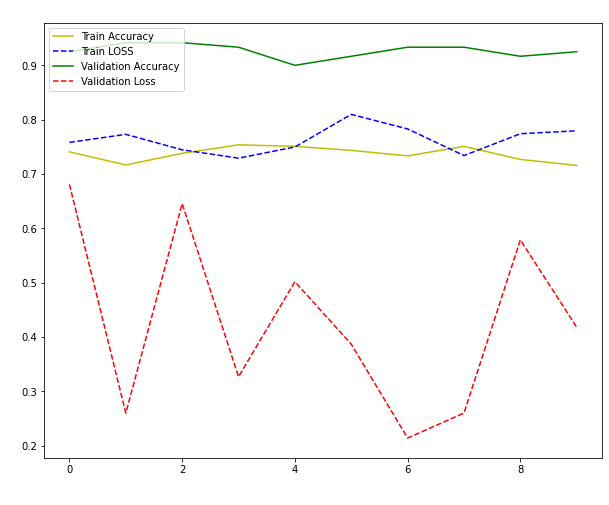

In [ ]:
# summarize history for accuracy

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(TRAIN_ACCURACY, '-y', label='Train Accuracy')
plt.plot(TRAIN_LOSS, '--b', label='Train LOSS')
plt.plot(VALIDATION_ACCURACY, '-g', label='Validation Accuracy')
plt.plot(VALIDATION_LOSS, '--r', label='Validation Loss')
plt.title('Loss and Accuracy', color='#fff')
plt.ylabel('Valores', color='#fff')
plt.xlabel('K-FOLD', fontsize=20, color='#fff')
plt.legend(loc='upper left')
plt.show()

# Testando o modelo

In [ ]:
classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'] 



In [ ]:
	test_generator = idg.flow_from_dataframe(training_data, directory = DATASET,
						       x_col = "id", y_col = "classes",
						       class_mode = "categorical", shuffle = True)

Found 1080 validated image filenames belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(299, 299),
        color_mode="rgb",
        shuffle = True,
        class_mode='categorical',
        batch_size=1)



Found 255 images belonging to 6 classes.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred= model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)


y_pred = np.argmax(pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

cm = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

cm = confusion_matrix(test_generator.classes, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'], 
                     columns = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Matrix de confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print('Classification Report')
report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
print(report)  


NameError: ignored

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


255/255 [==============================] - 102s 377ms/step


0.5008780487804878

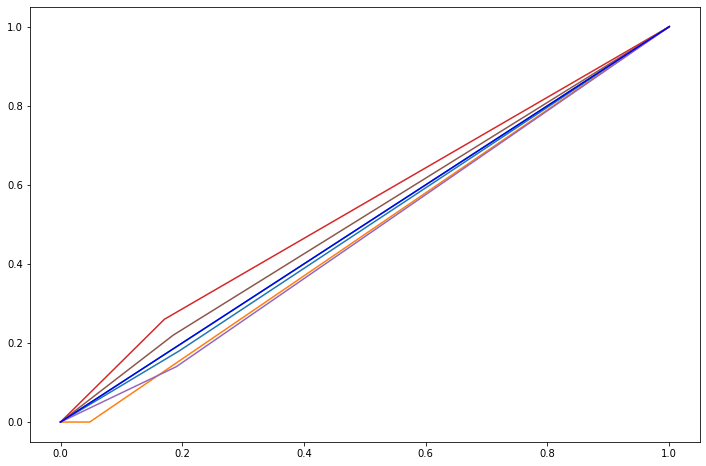

In [ ]:
from sklearn import preprocessing
from sklearn import metrics

classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(classificacoes): 
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

# calling
test_generator.reset() # resetting generator
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)



In [ ]:
from sklearn.metrics import confusion_matrix

predicted_class_indices=np.argmax(pred, axis=1)
labels=(test_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
#print(predicted_class_indices)
#print(labels)
#print(predictions)
confusion_matrix(predicted_class_indices, labels)



NameError: ignored

In [ ]:
#predicted_class_indices=np.argmax(pred,axis=1)

test_generator.classes
labels = test_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames= test_generator.filenames
results= pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

results.to_csv('drive/My Drive/resultados/resultado_INCEPTION' + str(TESTE_NUM) + '.csv',index=False)

NameError: ignored

In [78]:
from keras.models import load_model
from skimage import transform
import numpy
import re
from sklearn.metrics import classification_report, confusion_matrix
controle = 0

model = load_model(SAVED_MODELS + 'model_Inception_9.h5')

TEST_DIR = 'drive/My Drive/UMLstudies/Full_dataset_UML_test'
CSV_DATASET = 'drive/My Drive/UMLstudies/test_dataset_UML.csv'

train_data = pd.read_csv(CSV_DATASET)
classifica = train_data[['classes']]
n = classifica.count()

files = train_data[['id']]



classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']



dirname = TEST_DIR

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

# files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
# files.sort()



def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0


# print(train_data['id'][20])
# print(train_data['classes'][20])

count = 0
y_true = []
y_pred = []

for i in range(300):

  namefile = re.sub(r'_([0-9])\.', '_00\\1.', train_data['id'][i])
  namefile = re.sub(r'_([0-9])([0-9])\.', '_0\\1\\2.', namefile)

  image_path = os.path.join(dirname, namefile)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  classe_predita = np.argmax(predictions)

  # #print(train_data['id'][i])
  # print(train_data['classes'][i])
  # print(classificacoes[classe_predita])

  y_true.append(train_data['classes'][i])
  y_pred.append(classificacoes[classe_predita])

  if train_data['classes'][i] == classificacoes[classe_predita]:
    count += 1
  else:
    print(train_data['id'][i])
    print(train_data['classes'][i])
    print(classificacoes[classe_predita])
    print('---------------')


print(count)
print((count* 100)/300)
print(y_pred)
print(y_true)

data = confusion_matrix(y_true,y_pred)

  # image_path = os.path.join(dirname, train_data[['id']])
  # imagem = load(image_path)
  # predictions = model.predict(imagem)


# for file in files:

#   image_path = os.path.join(dirname, file)
#   imagem = load(image_path)
#   predictions = model.predict(imagem)

#   print(predictions)
#   classes = np.argmax(predictions)

#   print(file, classificacoes[classes])

#   if classificacoes[classes] == 'Component Diagram':
#     controle = controle + 1

# porcento = (controle * 100)/50
# print(predictions)
# print('Component Diagram')
# print('Acertos: ', controle)
# print('porcentage: ' + str(porcento) + '%')




O diretório existe!
Activity_Diagram_22.jpg
Activity Diagram
Component Diagram
---------------
Class_Diagram_1.jpg
Class Diagram
Component Diagram
---------------
Class_Diagram_3.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_8.jpg
Class Diagram
Activity Diagram
---------------
Class_Diagram_14.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_20.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_24.jpg
Class Diagram
Component Diagram
---------------
Class_Diagram_29.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_31.jpg
Class Diagram
Component Diagram
---------------
Class_Diagram_34.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_40.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_45.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_46.jpg
Class Diagram
Deployment Diagram
---------------
Class_Diagram_48.jpg
Class Diagram
Deployment Diagram
---------------
Cla

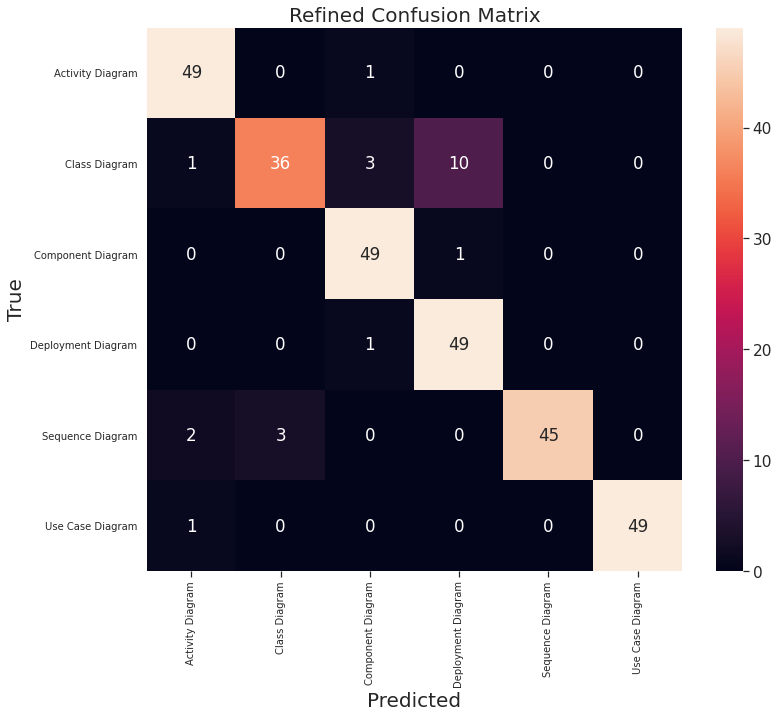

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt



labels = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']
 
cm = confusion_matrix(y_true,y_pred)

class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(12, 10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [55]:
from keras.models import load_model
from skimage import transform
controle = 0

model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Component_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Component Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Component Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório não existe!


FileNotFoundError: ignored

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Activity_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Activity Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Activity Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório existe!
[[9.99557197e-01 2.83852987e-05 1.14003740e-06 1.20268836e-04
  1.98962698e-05 2.73090322e-04]]
Activity_Diagram_001.jpg Activity Diagram
[[9.9999583e-01 2.1148193e-08 6.1903717e-07 3.2361197e-06 2.9460105e-07
  4.7093796e-08]]
Activity_Diagram_002.jpg Activity Diagram
[[9.9958211e-01 4.8935981e-05 9.0940921e-06 3.3155302e-04 5.7151947e-06
  2.2568513e-05]]
Activity_Diagram_003.jpg Activity Diagram
[[7.3439940e-03 1.7484393e-06 2.6469860e-07 9.9265176e-01 2.9523321e-07
  1.9981919e-06]]
Activity_Diagram_004.jpg Deployment Diagram
[[6.7809612e-01 1.6427610e-06 5.7527910e-07 3.2180366e-01 6.6010638e-05
  3.2030992e-05]]
Activity_Diagram_005.jpg Activity Diagram
[[9.9965143e-01 6.2556995e-07 9.5413455e-08 3.4437899e-04 7.1758997e-08
  3.4371224e-06]]
Activity_Diagram_006.jpg Activity Diagram
[[9.9816871e-01 2.3278371e-05 1.6499833e-03 3.2572578e-05 3.1370841e-05
  9.4094794e-05]]
Activity_Diagram_007.jpg Activity Diagram
[[9.9784303e-01 1.5392754e-05 1.1604797e-05 2.11

In [ ]:
print(model.predict)

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Use_case_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Use Case Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Use Case Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório existe!
[[0.00270201 0.0021452  0.4007501  0.5887311  0.00112705 0.0045445 ]]
Use_Case_Diagram_001.jpg Deployment Diagram
[[0.00254467 0.00336279 0.13314624 0.23850748 0.00535229 0.6170865 ]]
Use_Case_Diagram_002.jpg Use Case Diagram
[[0.03169661 0.04367873 0.11485791 0.0385945  0.01522838 0.7559439 ]]
Use_Case_Diagram_003.jpg Use Case Diagram
[[0.02409071 0.01461426 0.05006249 0.01288025 0.02738881 0.87096345]]
Use_Case_Diagram_004.jpg Use Case Diagram
[[5.2849246e-06 3.3128340e-06 5.4736491e-05 2.5858302e-05 1.2201488e-05
  9.9989867e-01]]
Use_Case_Diagram_005.jpg Use Case Diagram
[[5.8988290e-04 1.0994230e-03 2.3418886e-03 4.3472759e-03 2.9512614e-04
  9.9132639e-01]]
Use_Case_Diagram_006.jpg Use Case Diagram
[[6.1709456e-05 3.8051716e-05 3.2460736e-04 2.8082970e-04 2.7013788e-05
  9.9926776e-01]]
Use_Case_Diagram_007.jpg Use Case Diagram
[[0.00432487 0.04123418 0.07452309 0.3530955  0.0094298  0.5173926 ]]
Use_Case_Diagram_008.jpg Use Case Diagram
[[0.05537774 0.0211003

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Deployment_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Deployment Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Deployment Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório existe!
[[6.3531034e-12 2.5687761e-12 3.9198882e-13 1.0000000e+00 3.7970495e-12
  9.8646914e-14]]
Deployment_Diagram_001.jpg Deployment Diagram
[[5.2548251e-07 2.8125420e-05 2.4054939e-06 9.9996877e-01 5.8915468e-08
  1.7691748e-07]]
Deployment_Diagram_002.jpg Deployment Diagram
[[3.1198442e-07 2.7828223e-06 1.4541985e-08 9.9999690e-01 6.4840300e-10
  2.7561936e-10]]
Deployment_Diagram_003.jpg Deployment Diagram
[[1.07043256e-07 7.15532849e-07 2.10455783e-05 9.99977827e-01
  1.41020465e-07 8.89862193e-08]]
Deployment_Diagram_004.jpg Deployment Diagram
[[4.1371817e-07 3.3457266e-07 5.9752686e-08 9.9999917e-01 2.6896902e-09
  5.0521227e-09]]
Deployment_Diagram_005.jpg Deployment Diagram
[[5.4808741e-05 2.3249793e-05 1.0274939e-05 9.9991119e-01 2.3678118e-07
  2.3351697e-07]]
Deployment_Diagram_006.jpg Deployment Diagram
[[1.1602926e-11 9.2879336e-11 1.4668663e-09 1.0000000e+00 4.7363146e-12
  3.6742983e-13]]
Deployment_Diagram_007.jpg Deployment Diagram
[[7.9253134e-08 2.0601

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Sequence_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Sequence Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Sequence Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório existe!
[[0.01366788 0.33239344 0.36733082 0.03543599 0.24894114 0.00223073]]
Sequence_Diagram_001.jpg Component Diagram
[[1.6666337e-07 1.9842187e-07 3.7110692e-09 5.8889416e-08 9.9999952e-01
  1.0070008e-08]]
Sequence_Diagram_002.jpg Sequence Diagram
[[3.2051353e-04 1.0927029e-05 1.0477095e-04 6.9448244e-05 9.9948370e-01
  1.0593314e-05]]
Sequence_Diagram_003.jpg Sequence Diagram
[[4.9958702e-16 5.2874279e-13 7.6589265e-18 1.0534019e-15 1.0000000e+00
  1.4341282e-16]]
Sequence_Diagram_004.jpg Sequence Diagram
[[1.8933318e-07 5.2347279e-08 1.4496278e-08 2.2969455e-09 9.9999976e-01
  4.3401894e-08]]
Sequence_Diagram_005.jpg Sequence Diagram
[[2.6790317e-04 5.0515453e-03 4.0554455e-03 5.0016433e-02 9.4031483e-01
  2.9384627e-04]]
Sequence_Diagram_006.jpg Sequence Diagram
[[1.6618137e-06 4.8690826e-08 5.4996583e-08 7.2427900e-07 9.9999714e-01
  3.0886392e-07]]
Sequence_Diagram_007.jpg Sequence Diagram
[[1.20776775e-08 2.57981303e-09 6.30155025e-11 2.01406565e-11
  1.00000000e

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_Inception_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Class_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (299, 299, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Class Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Class Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




O diretório existe!
[[1.1505284e-04 7.0258731e-01 1.2852509e-02 2.8332779e-01 6.1737379e-04
  4.9995456e-04]]
Class_Diagram_002.jpg Class Diagram
[[4.0392278e-04 4.7611967e-02 7.7405543e-04 9.5099056e-01 8.6666325e-05
  1.3285801e-04]]
Class_Diagram_003.jpg Deployment Diagram
[[0.16212931 0.41654974 0.05662977 0.0318995  0.29664683 0.03614482]]
Class_Diagram_004.jpg Class Diagram
[[0.0021909  0.8142036  0.15722103 0.00943429 0.01064971 0.00630051]]
Class_Diagram_005.jpg Class Diagram
[[1.6754355e-04 9.6883965e-01 2.2083249e-02 6.6979057e-03 1.8039241e-03
  4.0772109e-04]]
Class_Diagram_006.jpg Class Diagram
[[1.0071990e-04 9.9831426e-01 5.8243261e-04 5.2148383e-04 6.2231360e-05
  4.1886821e-04]]
Class_Diagram_007.jpg Class Diagram
[[0.5433605  0.03637097 0.01130215 0.40744466 0.0005732  0.00094853]]
Class_Diagram_008.jpg Activity Diagram
[[0.34872967 0.34958777 0.14044139 0.09277168 0.04835223 0.02011728]]
Class_Diagram_009.jpg Class Diagram
[[0.00222009 0.56922275 0.05100798 0.3648947